resources:
- https://distill.pub/2019/visual-exploration-gaussian-processes/
- https://ndcbe.github.io/cbe67701-uncertainty-quantification/10.03-Gaussian-Process-Regression.html
- https://domino.ai/blog/fitting-gaussian-process-models-python
- https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-co2-py
- https://www.cs.toronto.edu/~duvenaud/cookbook/

log space:
- https://github.com/dfm/george/issues/106
- https://www.osti.gov/servlets/purl/1847480

In [1]:
from utils import *
from map_utils import *
from models import *
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF,
    ConstantKernel,
    WhiteKernel,
    RationalQuadratic,
)
import pickle
from sklearn.metrics import (
    root_mean_squared_error,
    mean_squared_error,
    mean_absolute_error,
)
import numpy as np
import seaborn as sns
import matplotlib
import shapely
from matplotlib.colors import LogNorm
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import TransformerMixin
from sklearn.compose import TransformedTargetRegressor

/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
region = 'world'
points, training, validation = get_from_region(region=region)

Cross-validated averaged metrics...
 Training RMSE: 54.56004749262236
 Training MAE: 26.449484376592135
 Validation RMSE: 71.79445096193828
 Validation MAE: 32.34225416983296

Loading country shapes...
Transforming heatmap...
max map waiting time: 1440.0
min map waiting time: -1.0
Plotting heatmap...
max waiting time: 675


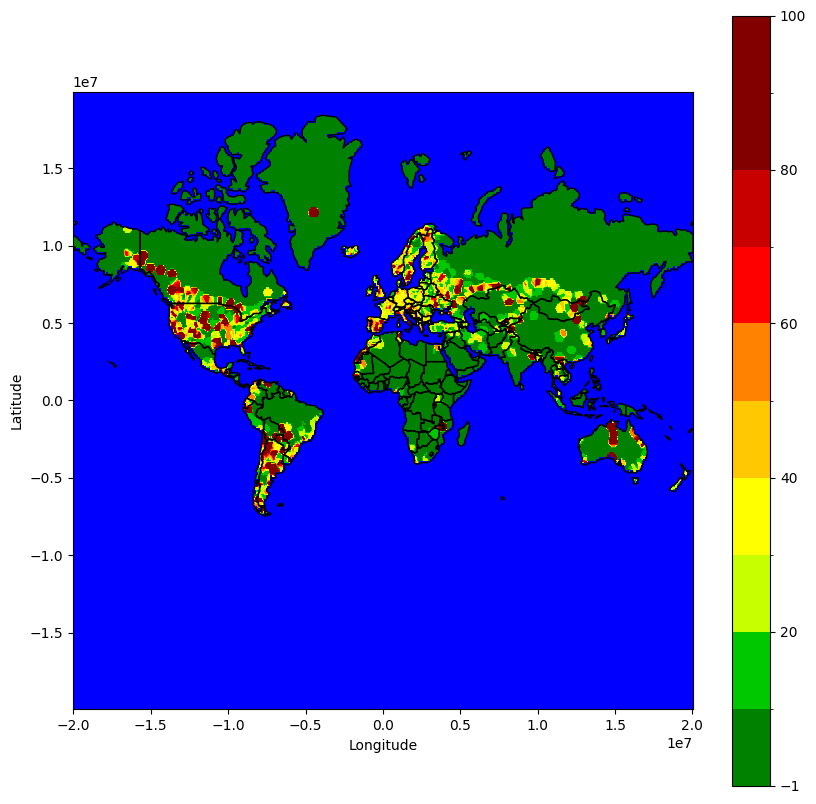

In [3]:
wag_model = WeightedAveragedGaussian(region=region)
wag_model = evaluate_cv(estimator=wag_model, X=points[["lon", "lat"]].values, y=points["wait"])
wag_model.build_map()

Cross-validated averaged metrics...
 Training RMSE: 68.16798017648341
 Training MAE: 32.690935784633645
 Validation RMSE: 67.66817787259981
 Validation MAE: 32.693214706965904



  9%|▊         | 310/3600 [00:00<00:01, 3078.23it/s]

100%|██████████| 3600/3600 [00:33<00:00, 106.14it/s]


Loading country shapes...
Transforming heatmap...
max map waiting time: 37.83173530673531
min map waiting time: 37.83173530673531
Plotting heatmap...
max waiting time: 675


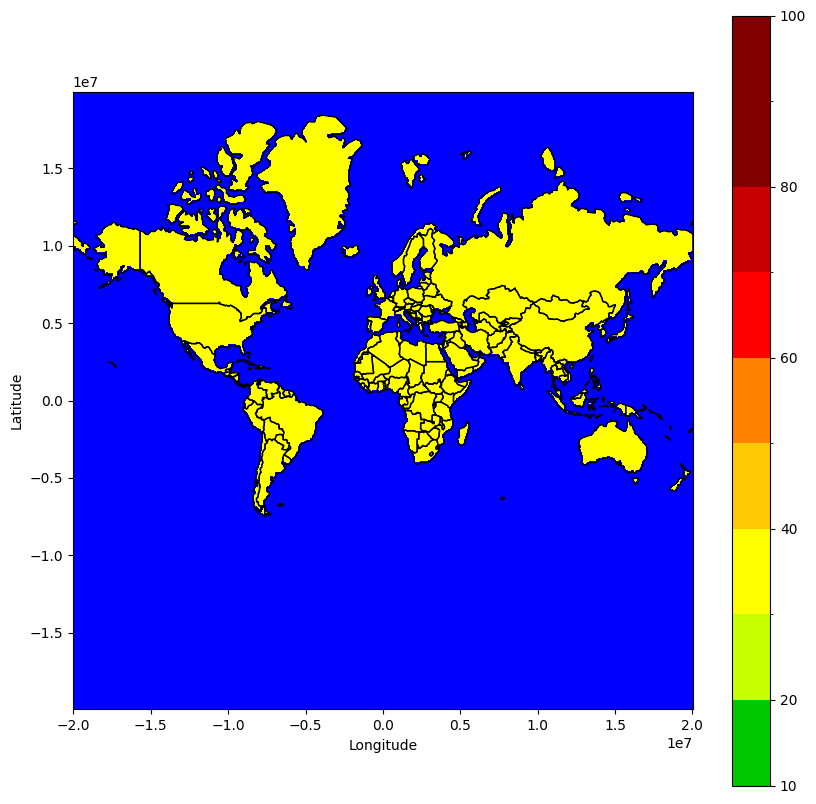

In [4]:
average_model = Average()
average_model = evaluate_cv(estimator=average_model, X=points[["lon", "lat"]].values, y=points["wait"])
map_from_model(average_model, region=region)

Cross-validated averaged metrics...
 Training RMSE: 58.65517769924577
 Training MAE: 28.56974396754986
 Validation RMSE: 70.701071511297
 Validation MAE: 32.37224523763671



100%|██████████| 3600/3600 [01:59<00:00, 30.09it/s]


Loading country shapes...
Transforming heatmap...
max map waiting time: 1440.0
min map waiting time: 0.0
Plotting heatmap...
max waiting time: 675


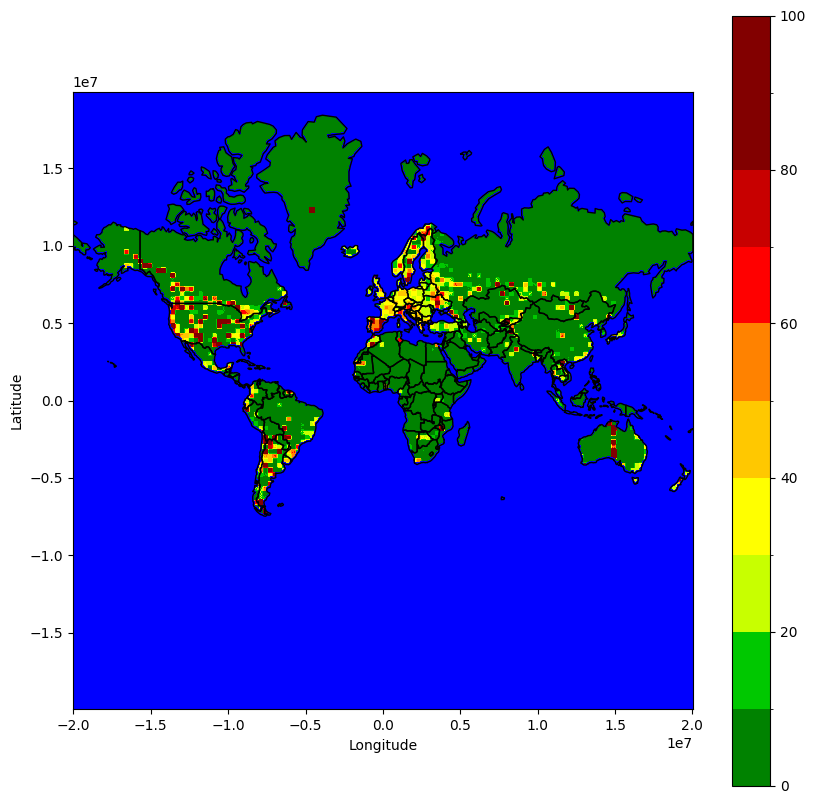

In [5]:
tiles_model = Tiles(region=region)
tiles_model = evaluate_cv(estimator=tiles_model, X=points[["lon", "lat"]].values, y=points["wait"])
map_from_model(tiles_model, region=region)

In [6]:
X = points[['lon', 'lat']].values
y = points['wait'].values


log_transformer = get_log_transformer()
y_transformed = log_transformer.fit_transform(y)

sigma = np.std(y_transformed)

kernel = ConstantKernel(constant_value=sigma**2, constant_value_bounds='fixed') * RBF(
    length_scale_bounds=(1e4, 1e6)
) + WhiteKernel(noise_level_bounds=(1e-1, 1e1))


gpr = get_gpr(kernel)
gpr = evaluate_cv(estimator=gpr, X=X, y=y)
print(gpr.regressor_.kernel_)
map_from_model(gpr, region=region)

In [ ]:
stop

NameError: name 'stop' is not defined

# Data

In [ ]:
points = get_points('../data/points_train.csv')
region = 'germany'
points, polygon, map_boundary = get_points_in_region(points, region)
print(len(points))

points = get_points('../data/points_train.csv')
region = 'europe'
points, polygon, map_boundary = get_points_in_region(points, region)
print(len(points))

points = get_points('../data/points_train.csv')
region = 'world'
points, polygon, map_boundary = get_points_in_region(points, region)
print(len(points))

2069
8444
9871


# 1D lon

In [ ]:
points = get_points('../data/artificial_points_gp.csv')

points = points[points.lat == 0]

points['lat'] = points.geometry.y
points['lon'] = points.geometry.x

X = points[['lon']].values
y = points['wait'].values

# assuming mean = 0 in the gp setup
average = np.mean(y)

test_start = 1000000
test_stop = 2600000

In [ ]:
points = get_points('../data/points_train.csv')
region = 'germany'
points, polygon, map_boundary = get_points_in_region(points, region)

points['lat'] = points.geometry.y
points['lon'] = points.geometry.x

vertical_cut = 6621293 # cutting Germany vertically through Dresden
offset = 10000 # 10km strip
points = points[(points.lat > vertical_cut - offset) & (points.lat < vertical_cut + offset)]

val = get_points('../data/points_val.csv')
val, polygon, map_boundary = get_points_in_region(val, region)
val['lat'] = val.geometry.y
val['lon'] = val.geometry.x

val = val[(val.lat > vertical_cut - offset) & (val.lat < vertical_cut + offset)]

# ->
test_start = 0.4e6
test_stop = 1.7e6

Weighting gaussians for all points...


100%|██████████| 75/75 [00:00<00:00, 266.49it/s]


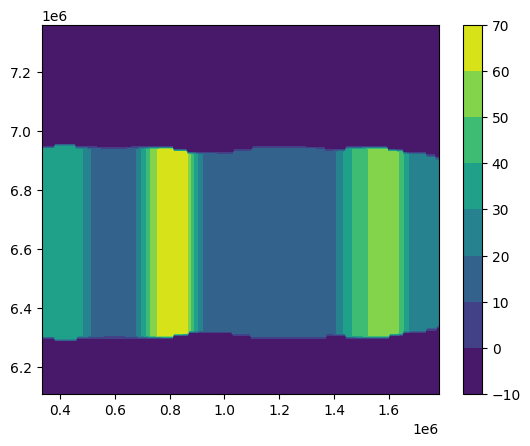

In [ ]:
points.geometry = points.geometry.map(lambda point: shapely.ops.transform(lambda x, y: (x, vertical_cut), point))
val.geometry = val.geometry.map(lambda point: shapely.ops.transform(lambda x, y: (x, vertical_cut), point))

X, Y, Z_raw, Zn, Zn_w = make_raster_map(points, region, polygon, map_boundary)
save_as_raster(Z_raw, polygon, map_boundary)

plt.contourf(X, Y, Z_raw)
plt.colorbar()
plt.show()

In [ ]:
raster = load_raster()

points["pred"] = points.progress_apply(lambda x: map_predict(x.lon, x.lat, raster), axis=1)

print((mean_squared_error(points["wait"], points["pred"]), 
root_mean_squared_error(points["wait"], points["pred"]),
mean_absolute_error(points["wait"], points["pred"])))

val['pred'] = val.progress_apply(lambda x: map_predict(x.lon, x.lat, raster), axis=1)

print((mean_squared_error(val['wait'], val['pred']),
root_mean_squared_error(val['wait'], val['pred']),
mean_absolute_error(val['wait'], val['pred'])))

100%|██████████| 75/75 [00:00<00:00, 7622.87it/s]


(2178.974814814815, 46.679490301574795, 22.631111111111114)


100%|██████████| 27/27 [00:00<00:00, 7210.84it/s]

(381.3888888888889, 19.529180445909372, 14.444444444444445)


In [ ]:
X = points[['lon']].values
y = points['wait'].values

# y_ being the waiting time in the (new) log space
# log space allows us to contrain the prior of functions (in the original space)
# to functions being always positive
# underlying cause: the original ys are not normally distributed (as they do not become less than 0)
# TODO: alternatively, try a probit function to constrain an upper bound as well
y_ = np.log(y)

# scaling the noise so that it proportinally the same as in the non-log space
# TODO: this is a hot-fix: look into the mathematically correct solution
# TODO: move noise_per_datapoint to experimental section
noise_per_datapoint = v_noise_from_waiting_time(y_)
# noise_proportion = noise_per_datapoint / y
# noise_per_datapoint = noise_proportion * (y_ - 1)

# assuming mean = 0 in the gp setup
average = np.mean(y_)
y_ = y_ - average
stdv = np.std(y_)

<ErrorbarContainer object of 3 artists>

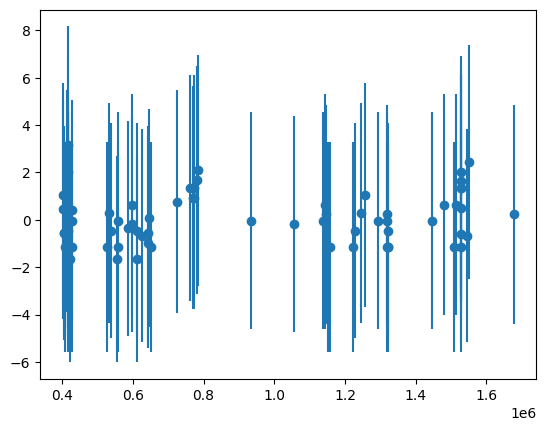

In [ ]:
# 95% confidence interval
plt.errorbar(X, y_, yerr=noise_per_datapoint * 1.96, fmt="o", capsize=0)

## fixed parameters & log space

In [ ]:
l = 5e4
sigma = stdv

print(sigma**2)
# setting kernel bounds to 'fixed' to prevent them from being fitted
# kernel design: https://www.cs.toronto.edu/~duvenaud/cookbook/ https://gaussianprocess.org/gpml/chapters/RW.pdf
# long term trends (due to traditions in regions) -> RBF
# points appear in bulk (mostly where streets cross) there we have some low waiting times but also a spike of high waiting times
# some noise (from measurement errors & from pure coincidence of being picked up [irregularities]) -> WhiteKernel
# periodic, rational quadratic and extra rbf kernel did not improve the results - only introduced mini spikes to better fit the training data
rbf = RBF(length_scale=l, length_scale_bounds='fixed')
kernel = ConstantKernel(constant_value=sigma**2, constant_value_bounds='fixed') * rbf

gp = GaussianProcessRegressor(
    kernel=kernel,
    alpha=noise_per_datapoint**2,
    optimizer="fmin_l_bfgs_b",  # maximizing marginal log lik: given the data, how likely is the parameterization of the kernel
    # (if we draw a sample frome the multivariate gaussian with the kernel as covariance matrix, how likely is the data we have seen)
    # prevents overfitting to some degree
    normalize_y=False,
    n_restarts_optimizer=100,
    random_state=42,
)

gp.fit(X, y_)
gp.kernel_, np.exp(gp.kernel_.theta)

1.103976124192544


(1.05**2 * RBF(length_scale=5e+04), array([], dtype=float64))

In [ ]:
l = 5e4
sigma = stdv

print(sigma**2)
# setting kernel bounds to 'fixed' to prevent them from being fitted
rbf = RBF(length_scale=l, length_scale_bounds=(1e-100,1e100))
kernel = ConstantKernel(constant_value=sigma**2, constant_value_bounds='fixed') * rbf + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-100,1e100))

gp = GaussianProcessRegressor(
    kernel=kernel,
    alpha=0.0**2,
    optimizer="fmin_l_bfgs_b",  # maximizing marginal log lik: given the data, how likely is the parameterization of the kernel
    # (if we draw a sample frome the multivariate gaussian with the kernel as covariance matrix, how likely is the data we have seen)
    # prevents overfitting to some degree
    normalize_y=False,
    n_restarts_optimizer=0,
    random_state=42,
)

gp.fit(X, y_)
gp.kernel_, np.exp(gp.kernel_.theta)

1.103976124192544


/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-100. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


(1.05**2 * RBF(length_scale=1e-100) + WhiteKernel(noise_level=1.69e-45),
 array([1.00000000e-100, 1.68916968e-045]))

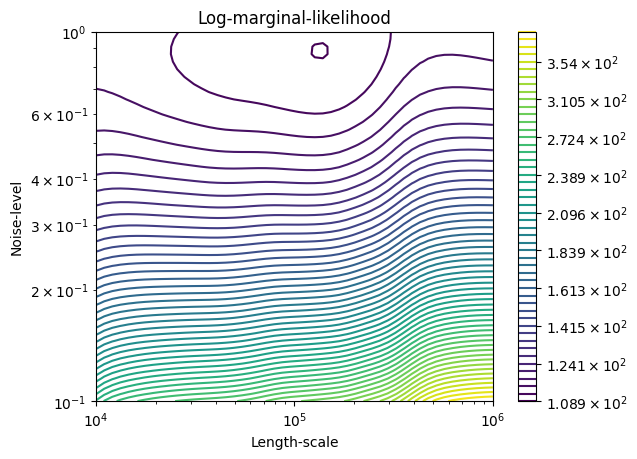

In [ ]:
length_scale = np.logspace(4, 6, num=50)
noise_level = np.logspace(-1, 0, num=50)
length_scale_grid, noise_level_grid = np.meshgrid(length_scale, noise_level)

log_marginal_likelihood = [
    gp.log_marginal_likelihood(theta=np.log([scale, noise]))
    for scale, noise in zip(length_scale_grid.ravel(), noise_level_grid.ravel())
]
log_marginal_likelihood = np.reshape(
    log_marginal_likelihood, newshape=noise_level_grid.shape
)

vmin, vmax = (-log_marginal_likelihood).min(), (-log_marginal_likelihood).max()
level = np.around(np.logspace(np.log10(vmin), np.log10(vmax), num=50), decimals=1)
plt.contour(
    length_scale_grid,
    noise_level_grid,
    -log_marginal_likelihood,
    levels=level,
    norm=LogNorm(vmin=vmin, vmax=vmax),
)
plt.colorbar()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Length-scale")
plt.ylabel("Noise-level")
plt.title("Log-marginal-likelihood")
plt.show()

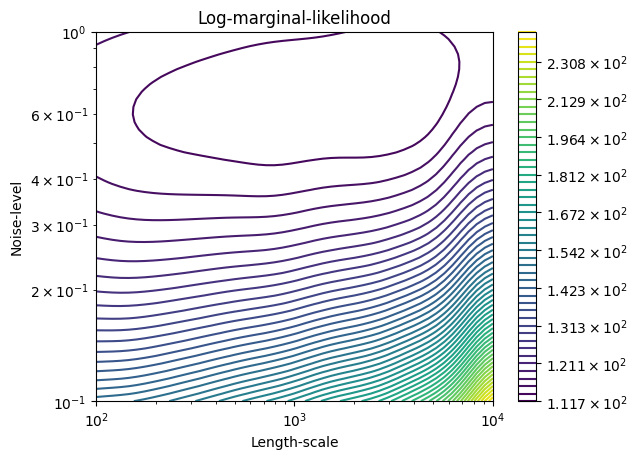

In [ ]:
length_scale = np.logspace(2, 4, num=50)
noise_level = np.logspace(-1, 0, num=50)
length_scale_grid, noise_level_grid = np.meshgrid(length_scale, noise_level)

log_marginal_likelihood = [
    gp.log_marginal_likelihood(theta=np.log([scale, noise]))
    for scale, noise in zip(length_scale_grid.ravel(), noise_level_grid.ravel())
]
log_marginal_likelihood = np.reshape(
    log_marginal_likelihood, newshape=noise_level_grid.shape
)

vmin, vmax = (-log_marginal_likelihood).min(), (-log_marginal_likelihood).max()
level = np.around(np.logspace(np.log10(vmin), np.log10(vmax), num=50), decimals=1)
plt.contour(
    length_scale_grid,
    noise_level_grid,
    -log_marginal_likelihood,
    levels=level,
    norm=LogNorm(vmin=vmin, vmax=vmax),
)
plt.colorbar()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Length-scale")
plt.ylabel("Noise-level")
plt.title("Log-marginal-likelihood")
plt.show()

# -> looks good but length scale is unrealistically low

In [ ]:
l = 5e4
sigma = stdv

print(sigma**2)
# setting kernel bounds to 'fixed' to prevent them from being fitted
rbf = RBF(length_scale=l, length_scale_bounds=(1e4, 3e5))
kernel = ConstantKernel(constant_value=sigma**2, constant_value_bounds='fixed') * rbf + WhiteKernel(noise_level=1e-5, noise_level_bounds=(4e-1, 1e0))

gp = GaussianProcessRegressor(
    kernel=kernel,
    alpha=0.0**2,
    optimizer="fmin_l_bfgs_b",  # maximizing marginal log lik: given the data, how likely is the parameterization of the kernel
    # (if we draw a sample frome the multivariate gaussian with the kernel as covariance matrix, how likely is the data we have seen)
    # prevents overfitting to some degree
    normalize_y=False,
    n_restarts_optimizer=100,
    random_state=42,
)

gp.fit(X, y_)
gp.kernel_, np.exp(gp.kernel_.theta)

1.103976124192544


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:01<00:00, 88.44it/s]


(1.05**2 * RBF(length_scale=1.35e+05) + WhiteKernel(noise_level=0.886),
 array([1.34822251e+05, 8.85996141e-01]))

In [ ]:
# training error
points["pred"] = points.apply(lambda x: gp.predict([x[['lon']].values], return_std=False), axis=1)
points["pred"] = np.exp(points["pred"] + average)

(mean_squared_error(points["wait"], points["pred"]), 
root_mean_squared_error(points["wait"], points["pred"]),
mean_absolute_error(points["wait"], points["pred"]))

ValueError: Unsupported dtype object

In [ ]:
import sklearn
sklearn.__file__

'/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/__init__.py'

In [ ]:
# validation error
val['pred'], val['std'] = gp.predict(val[['lon']].values, return_std=True)
val['pred'] = np.exp(val['pred'] + average)

(mean_squared_error(val['wait'], val['pred']),
root_mean_squared_error(val['wait'], val['pred']),
mean_absolute_error(val['wait'], val['pred']))

(413.67337973523695, 20.338962110570858, 13.557554926663821)

In [ ]:
# baseline
points["baseline"] = np.exp(average)

print((mean_squared_error(points["wait"], points["baseline"]), 
root_mean_squared_error(points["wait"], points["baseline"]),
mean_absolute_error(points["wait"], points["baseline"])))

val['baseline'] = np.exp(average)

print((mean_squared_error(val['wait'], val['baseline']),
root_mean_squared_error(val['wait'], val['baseline']),
mean_absolute_error(val['wait'], val['baseline'])))

(2763.7821337141736, 52.57168566551936, 22.87447692176339)
(471.7953159066285, 21.720849797064307, 15.378198188607064)


Text(0, 0.5, '$f(x)$')

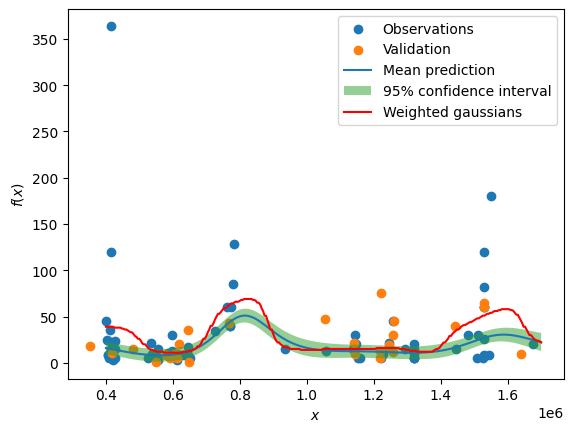

In [ ]:
x_test = np.linspace(start=test_start, stop=test_stop, num=300)
x_test = np.array([[xi] for xi in x_test])

y_pred, std_prediction = gp.predict(x_test, return_std=True)
y_pred = np.exp(y_pred + average) # add back the mean

plt.scatter(X, y, label="Observations")
plt.scatter(val.lon, val.wait, label="Validation")
plt.plot(x_test, y_pred, label="Mean prediction")
plt.fill_between(
    x_test.ravel(),
    y_pred - np.exp(1.96 * std_prediction),
    y_pred + np.exp(1.96 * std_prediction),
    alpha=0.5,
    label=r"95% confidence interval",
)

y_pred_wg = [map_predict(lon, vertical_cut, raster) for lon in x_test]
plt.plot(x_test, y_pred_wg, label="Weighted gaussians", color="red")

plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")

# TODO: getting the real stdv in the original space see:
# https://stats.stackexchange.com/questions/401941/mean-and-error-bounds-of-log-transformed-data-using-gaussian-process-regression

Text(0, 0.5, '$f(x)$')

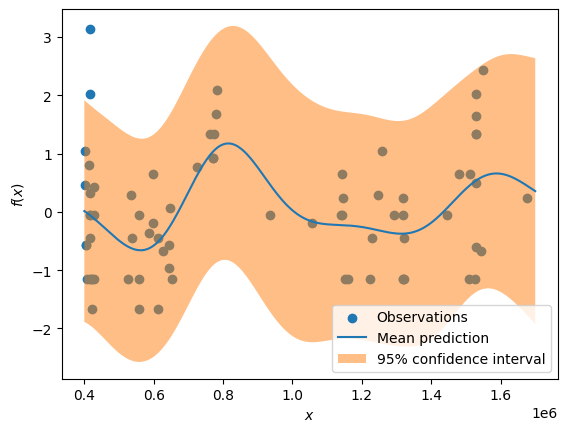

In [ ]:
# plot in the log space

x_test = np.linspace(start=test_start, stop=test_stop, num=300)
x_test = np.array([[xi] for xi in x_test])

y_pred, std_prediction = gp.predict(x_test, return_std=True)

plt.scatter(X, y_, label="Observations")
plt.plot(x_test, y_pred, label="Mean prediction")
plt.fill_between(
    x_test.ravel(),
    y_pred - 1.96 * std_prediction,
    y_pred + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)

plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")

# TODO: what does a quite equal confidence interval indicate? as seen below

In [ ]:
stop

NameError: name 'stop' is not defined

## optimize parameters

In [ ]:
# larger rbf sigma (stdv) to allow deviation from 0 (mean) -> factor before rbf kernel via constant kernel -> sigma
# larger rbf length scale for more smoothness; assume "no" influence beyond length scale -> length scale of rbf kernel -> l

# error (noise) stdv added to diagonal of kernel matrix as parameter -> alpha

# parameters to optimize
sigma = 10.0
sigma_bounds = (1e-1,1e7) # unit are minutes

l = 1e6  # only lon dimensions; set starting value to 1000km
length_scale_bounds = (5e4, 1e7) # from the scatter plot above; in the metirc crs this implies influence between 10km and 10000km

alpha = 0.0 # as WhiteKernel is used to optimized noise

noise_level = 1.0
noise_level_bounds = (1e-1,1e1)  # unit are minutes

rbf = RBF(
    length_scale=l, length_scale_bounds=length_scale_bounds
)

kernel = ConstantKernel(
    constant_value=sigma, constant_value_bounds=sigma_bounds
) * rbf # + WhiteKernel(noise_level=noise_level, noise_level_bounds=noise_level_bounds)

gp = GaussianProcessRegressor(
    kernel=kernel,
    alpha=noise_per_datapoint**2,
    optimizer="fmin_l_bfgs_b",  # maximizing marginal log lik: given the data, how likely is the parameterization of the kernel
    # (if we draw a sample frome the multivariate gaussian with the kernel as covariance matrix, how likely is the data we have seen)
    # prevents overfitting to some degree
    normalize_y=False,
    n_restarts_optimizer=1000,
    random_state=42,
)

# try adujusting the mean to 0 vs. setting normalize_y to True (this is not preferred as it also standardizes which results in less intuitive kernel parameters)
# setting noise per datapoint with more noise on larger values

# WhiteKernel can be used instead of alpha to optimize noise (per datapoint) as well -> set alpha to 0
# set WhiteKernel bounds narrow to not overfit noise (everything is explained by noise)

In [ ]:
gp.fit(X, y - average)

  6%|▌         | 58/1000 [00:00<00:01, 577.40it/s]

100%|██████████| 1000/1000 [00:01<00:00, 608.30it/s]
/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 10000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 50000.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(alpha=array([0.12392085, 0.18287664, 0.14179802, 0.79187921, 0.63725288,
       0.63725288, 0.24291604, 0.63725288, 0.06920143, 0.35978813,
       0.04564283, 0.06920143, 0.63725288, 0.35978813, 0.03911104,
       0.0866607 , 0.09573131, 0.24291604, 0.04433995, 0.12392085,
       0.55959313, 0.41060596, 0.24291604, 0.32869004, 0.12392085,
       0.1104973 , 0.44105756, 0.18287664, 0.2146596 , 0.24291604,
       0.24291604, 0.06920143, 0.18287664, 0.05482803, 0.24291604,
       0.27960213, 0.63725288, 0.35978813, 0.63725288, 0.63725288,
       0.17433506, 0.27960213, 0.09573131, 0.12392085, 0.05603958,
       0.39673753, 0.24291604, 0.44105756, 0.06920143, 0.63725288,
       0.63725288, 0.63725288]),
                         kernel=3.16**2 * RBF(length_scale=1e+06),
                         n_restarts_optimizer=1000, random_state=42)

In [ ]:
gp.kernel_, np.exp(gp.kernel_.theta)
# note that length_scale and noise_level take the values at the bounds of the allowed range (indicator that this is not a local optimum)

(3.16e+03**2 * RBF(length_scale=5e+04),
 array([10000000.00000001,    50000.        ]))

In [ ]:
x_test = np.linspace(start=test_start, stop=test_stop, num=300)
x_test = np.array([[xi] for xi in x_test])

In [ ]:
y_pred, std_prediction = gp.predict(x_test, return_std=True)
y_pred = y_pred + average # add back the mean

Text(0, 0.5, '$f(x)$')

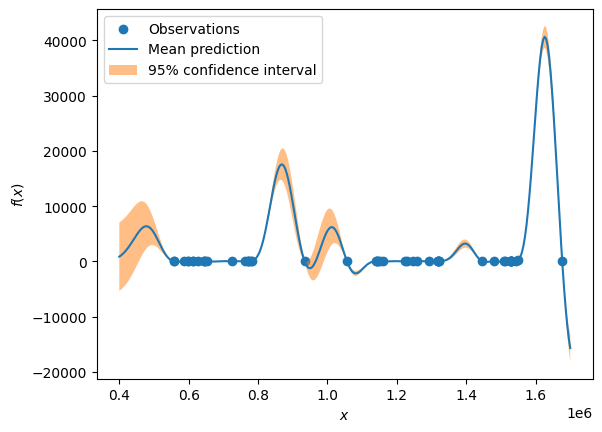

In [ ]:
plt.scatter(X, y, label="Observations")
plt.plot(x_test, y_pred, label="Mean prediction")
plt.fill_between(
    x_test.ravel(),
    y_pred - 1.96 * std_prediction,
    y_pred + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")

In [ ]:
# TODO: prevent getting hyperparameters at interval bounds

In [ ]:
stop

NameError: name 'stop' is not defined

# 2D lon lat

In [ ]:
# original space
points = get_points('../data/points_train.csv')
region = 'europe'
points, polygon, map_boundary = get_points_in_region(points, region)
points['lat'] = points.geometry.y
points['lon'] = points.geometry.x

X = points[['lat', 'lon']].values
y = points['wait'].values

noise_per_datapoint = v_noise_from_waiting_time(y)

average = np.mean(y)
stdv = np.std(y)

val = get_points('../data/points_val.csv')
val, polygon, map_boundary = get_points_in_region(val, region)
val['lat'] = val.geometry.y
val['lon'] = val.geometry.x

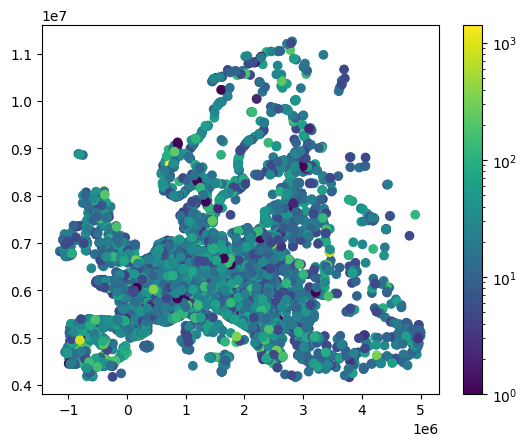

In [ ]:
plt.scatter(X[:,1], X[:,0], c=y, norm='log', label="Observations")
plt.colorbar()

## weighted gaussian

In [ ]:
resolution = 2

Weighting gaussians for all points...


100%|██████████| 2069/2069 [00:00<00:00, 20894.42it/s]


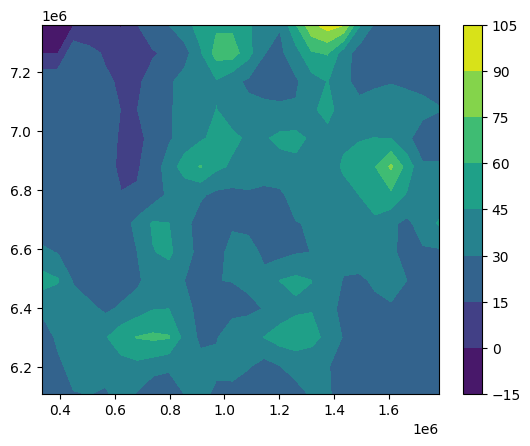

In [ ]:
points = get_points('../data/points_train.csv')
region = 'germany'
points, polygon, map_boundary = get_points_in_region(points, region)
points['lat'] = points.geometry.y
points['lon'] = points.geometry.x

val = get_points('../data/points_val.csv')
val, polygon, map_boundary = get_points_in_region(val, region)
val['lat'] = val.geometry.y
val['lon'] = val.geometry.x

X, Y, Z_raw, Zn, Zn_w = make_raster_map(points, region, polygon, map_boundary, resolution=resolution)
save_as_raster(Z_raw, polygon, map_boundary, region=region, method="ordinary", resolution=resolution)

plt.contourf(X, Y, Z_raw)
plt.colorbar()
plt.show()

In [ ]:
raster = load_raster(region=region, method="ordinary", resolution=resolution)

points["pred"] = points.progress_apply(lambda x: map_predict(x.lon, x.lat, raster), axis=1)

print((mean_squared_error(points["wait"], points["pred"]), 
root_mean_squared_error(points["wait"], points["pred"]),
mean_absolute_error(points["wait"], points["pred"])))

val['pred'] = val.progress_apply(lambda x: map_predict(x.lon, x.lat, raster), axis=1)

print((mean_squared_error(val['wait'], val['pred']),
root_mean_squared_error(val['wait'], val['pred']),
mean_absolute_error(val['wait'], val['pred'])))

100%|██████████| 2069/2069 [00:00<00:00, 14359.71it/s]


(2031.8336374625076, 45.075865354560946, 22.445252269734656)


100%|██████████| 687/687 [00:00<00:00, 14260.62it/s]

(1915.5765114978824, 43.7672995682608, 24.8576942072319)


Weighting gaussians for all points...


100%|██████████| 8444/8444 [00:05<00:00, 1592.41it/s]


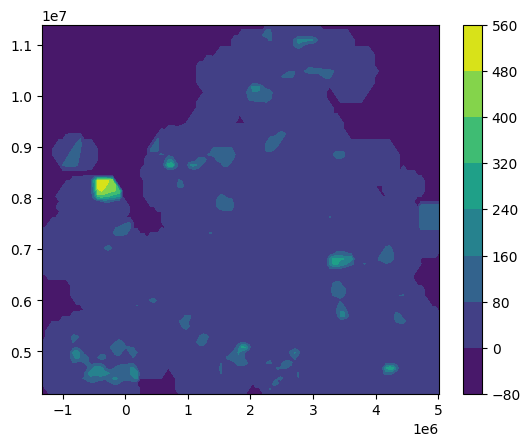

In [ ]:
points = get_points('../data/points_train.csv')
region = 'europe'
points, polygon, map_boundary = get_points_in_region(points, region)
points['lat'] = points.geometry.y
points['lon'] = points.geometry.x

val = get_points('../data/points_val.csv')
val, polygon, map_boundary = get_points_in_region(val, region)
val['lat'] = val.geometry.y
val['lon'] = val.geometry.x

X, Y, Z_raw, Zn, Zn_w = make_raster_map(points, region, polygon, map_boundary, resolution=resolution)
save_as_raster(Z_raw, polygon, map_boundary, region=region, method="ordinary", resolution=resolution)

plt.contourf(X, Y, Z_raw)
plt.colorbar()
plt.show()

In [ ]:
raster = load_raster(region=region, method="ordinary", resolution=resolution)

points["pred"] = points.progress_apply(lambda x: map_predict(x.lon, x.lat, raster), axis=1)

print((mean_squared_error(points["wait"], points["pred"]), 
root_mean_squared_error(points["wait"], points["pred"]),
mean_absolute_error(points["wait"], points["pred"])))

val['pred'] = val.progress_apply(lambda x: map_predict(x.lon, x.lat, raster), axis=1)

print((mean_squared_error(val['wait'], val['pred']),
root_mean_squared_error(val['wait'], val['pred']),
mean_absolute_error(val['wait'], val['pred'])))

100%|██████████| 8444/8444 [00:00<00:00, 14184.20it/s]


(3370.7392240662743, 58.058067691461055, 27.61250337108622)


100%|██████████| 2786/2786 [00:00<00:00, 14099.66it/s]

(3587.917343760899, 59.89922657064028, 29.942228031575986)


Weighting gaussians for all points...


100%|██████████| 9871/9871 [10:04<00:00, 16.32it/s]


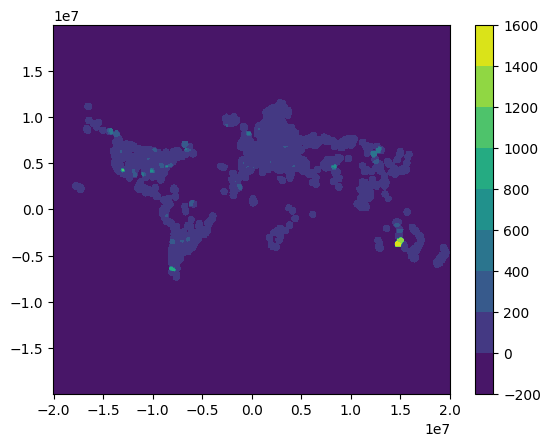

In [ ]:
points = get_points('../data/points_train.csv')
region = 'world'
points, polygon, map_boundary = get_points_in_region(points, region)
points['lat'] = points.geometry.y
points['lon'] = points.geometry.x

val = get_points('../data/points_val.csv')
val, polygon, map_boundary = get_points_in_region(val, region)
val['lat'] = val.geometry.y
val['lon'] = val.geometry.x

X, Y, Z_raw, Zn, Zn_w = make_raster_map(points, region, polygon, map_boundary, resolution=resolution)
save_as_raster(Z_raw, polygon, map_boundary, region=region, method="ordinary", resolution=resolution)

plt.contourf(X, Y, Z_raw)
plt.colorbar()
plt.show()

In [ ]:
raster = load_raster(region=region, method="ordinary", resolution=2)

points["pred"] = points.progress_apply(lambda x: map_predict(x.lon, x.lat, raster), axis=1)

print((mean_squared_error(points["wait"], points["pred"]), 
root_mean_squared_error(points["wait"], points["pred"]),
mean_absolute_error(points["wait"], points["pred"])))

val['pred'] = val.progress_apply(lambda x: map_predict(x.lon, x.lat, raster), axis=1)

print((mean_squared_error(val['wait'], val['pred']),
root_mean_squared_error(val['wait'], val['pred']),
mean_absolute_error(val['wait'], val['pred'])))

100%|██████████| 9871/9871 [00:01<00:00, 6825.31it/s]


(3214.9050673426427, 56.70013286882706, 26.280437738472706)


100%|██████████| 3286/3286 [00:00<00:00, 6863.38it/s]

(4639.923313625513, 68.11698256400905, 31.93364773920409)


In [ ]:
stop

## fixed params


### ordinary space

In [ ]:
# parameters to optimize
l = 9e4
L = [l, l]
sigma = stdv

rbf = RBF(
    length_scale=L, length_scale_bounds="fixed"
)  # using anisotripic kernel (different length scales for each dimension)

kernel = ConstantKernel(constant_value=sigma**2, constant_value_bounds="fixed") * rbf

gp = GaussianProcessRegressor(
    kernel=kernel,
    alpha=noise_per_datapoint**2,
    optimizer="fmin_l_bfgs_b",  # maximizing marginal log lik: given the data, how likely is the parameterization of the kernel
    # (if we draw a sample frome the multivariate gaussian with the kernel as covariance matrix, how likely is the data we have seen)
    # prevents overfitting to some degree
    normalize_y=False,
    n_restarts_optimizer=0,
    random_state=42,
)

gp.fit(X, y - average)
gp.kernel_, np.exp(gp.kernel_.theta)

ValueError: Found input variables with inconsistent numbers of samples: [720, 8444]

In [ ]:
# draw map

X, Y = get_map_grid(polygon, map_boundary, 10)
grid = np.array((Y, X)).T
map = np.empty((0, X.shape[0]))
certainty_map = np.empty((0, X.shape[0]))

for vertical_line in tqdm(grid):
    pred, stdv = gp.predict(vertical_line, return_std=True)
    map = np.vstack((map, pred + average))
    certainty_map = np.vstack((certainty_map, stdv))

map = map.T
certainty_map = certainty_map.T

  0%|          | 0/570 [00:00<?, ?it/s]

100%|██████████| 570/570 [09:36<00:00,  1.01s/it]


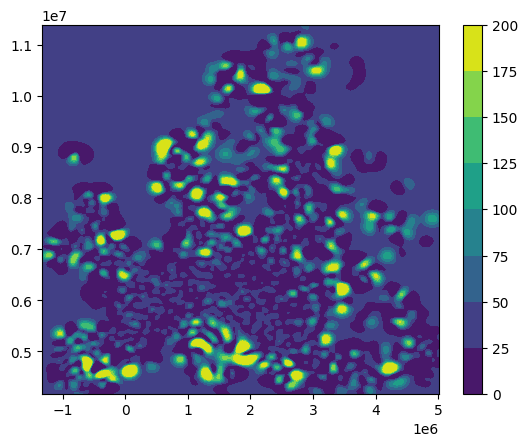

In [ ]:
map = np.clip(map, 0, 200)
plt.contourf(X, Y, map)
plt.colorbar()
plt.show()

In [ ]:
stop

NameError: name 'stop' is not defined

### log space

#### rqk

In [ ]:
# log space
points = get_points('../data/points_train.csv')
# for log transformation make sure waiting times are above 0 otherwise we get -inf for those values
points['wait'] = points['wait'].apply(lambda x: 0.1 if x == 0 else x)
region = 'europe'
points, polygon, map_boundary = get_points_in_region(points, region)
points['lat'] = points.geometry.y
points['lon'] = points.geometry.x

X = points[['lat', 'lon']].values
y = points['wait'].values

# y_ being the waiting time in the (new) log space
# log space allows us to contrain the prior of functions (in the original space)
# to functions being always positive
# underlying cause: the original ys are not normally distributed (as they do not become less than 0)
y_ = np.log(y)

# assuming mean = 0 in the gp setup
average = np.mean(y_)
y_ = y_ - average
stdv = np.std(y_)

1.07**2 * RationalQuadratic(alpha=0.0189, length_scale=7.11e+03) + WhiteKernel(noise_level=0.9) [1.89259350e-02 7.11131812e+03]
Calculating log marginal likelihood...


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Plotting...


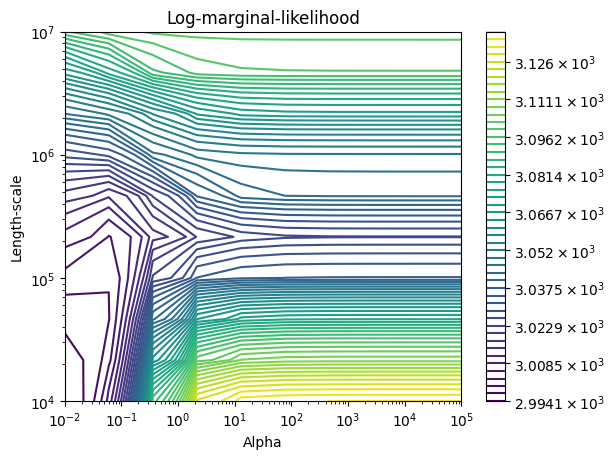

In [ ]:
# tuning hyperparameters

l = 1e5
L = [l, l]
sigma = stdv

rqk = RationalQuadratic(
    length_scale=1e5,
    alpha=1.0,
    length_scale_bounds=(1e-100, 1e100),
    alpha_bounds=(1e-100, 1e100),
)

kernel = ConstantKernel(
    constant_value=sigma**2, constant_value_bounds="fixed"
) * rqk + WhiteKernel(noise_level=0.9, noise_level_bounds="fixed")

gp = GaussianProcessRegressor(
    kernel=kernel,
    alpha=0.0**2,
    optimizer="fmin_l_bfgs_b",  # maximizing marginal log lik: given the data, how likely is the parameterization of the kernel
    # (if we draw a sample frome the multivariate gaussian with the kernel as covariance matrix, how likely is the data we have seen)
    # prevents overfitting to some degree
    normalize_y=False,
    n_restarts_optimizer=0,
    random_state=42,
)

# have to fit once before using log_marginal_likelihood
gp.fit(X, y_)
print(gp.kernel_, np.exp(gp.kernel_.theta))

num = 10
length_scale = np.logspace(-2, 5, num=num)
noise_level = np.logspace(4, 7, num=num)
length_scale_grid, noise_level_grid = np.meshgrid(length_scale, noise_level)

print("Calculating log marginal likelihood...")
log_marginal_likelihood = [
    gp.log_marginal_likelihood(theta=np.log([scale, noise]))
    for scale, noise in tqdm(zip(length_scale_grid.ravel(), noise_level_grid.ravel()), total=len(length_scale_grid.ravel()))
]
log_marginal_likelihood = np.reshape(
    log_marginal_likelihood, newshape=noise_level_grid.shape
)

print("Plotting...")
vmin, vmax = (-log_marginal_likelihood).min(), (-log_marginal_likelihood).max()
level = np.around(np.logspace(np.log10(vmin), np.log10(vmax), num=50), decimals=1)
plt.contour(
    length_scale_grid,
    noise_level_grid,
    -log_marginal_likelihood,
    levels=level,
    norm=LogNorm(vmin=vmin, vmax=vmax),
)
plt.colorbar()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Alpha")
plt.ylabel("Length-scale")
plt.title("Log-marginal-likelihood")
plt.show()

In [ ]:
# parameters to optimize

l = 1e5
L = [l, l]
sigma = stdv

rqk = RationalQuadratic(
    length_scale=1e5,
    alpha=1.0,
    length_scale_bounds=(1e2, 1e6),
    alpha_bounds=(1e-05, 100000.0),
)

kernel = ConstantKernel(
    constant_value=sigma**2, constant_value_bounds="fixed"
) * rqk + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-2, 1e2))

gp = GaussianProcessRegressor(
    kernel=kernel,
    alpha=0.0**2,
    optimizer="fmin_l_bfgs_b",  # maximizing marginal log lik: given the data, how likely is the parameterization of the kernel
    # (if we draw a sample frome the multivariate gaussian with the kernel as covariance matrix, how likely is the data we have seen)
    # prevents overfitting to some degree
    normalize_y=False,
    n_restarts_optimizer=0,
    random_state=42,
)

gp.fit(X, y_)
print(gp.kernel_, np.exp(gp.kernel_.theta))

# training error
points["pred"], points["std"] = gp.predict(X, return_std=True)
points["pred"] = np.exp(points["pred"] + average)

print(
    (
        mean_squared_error(points["wait"], points["pred"]),
        root_mean_squared_error(points["wait"], points["pred"]),
        mean_absolute_error(points["wait"], points["pred"]),
    )
)

# validation error
val = get_points("../data/points_val.csv")
val, polygon, map_boundary = get_points_in_region(val, region)
val["lat"] = val.geometry.y
val["lon"] = val.geometry.x

val["pred"], val["std"] = gp.predict(val[["lat", "lon"]].values, return_std=True)
val["pred"] = np.exp(val["pred"] + average)

print(
    (
        mean_squared_error(val["wait"], val["pred"]),
        root_mean_squared_error(val["wait"], val["pred"]),
        mean_absolute_error(val["wait"], val["pred"]),
    )
)

1.07**2 * RationalQuadratic(alpha=0.0188, length_scale=2.62e+03) + WhiteKernel(noise_level=0.861) [1.88084863e-02 2.61683880e+03 8.60656408e-01]
(2083.711587734089, 45.6476898400575, 18.094158152918364)
(2078.254661956861, 45.58787845422137, 22.183672707242767)


100%|██████████| 26/26 [00:00<00:00, 27.90it/s]


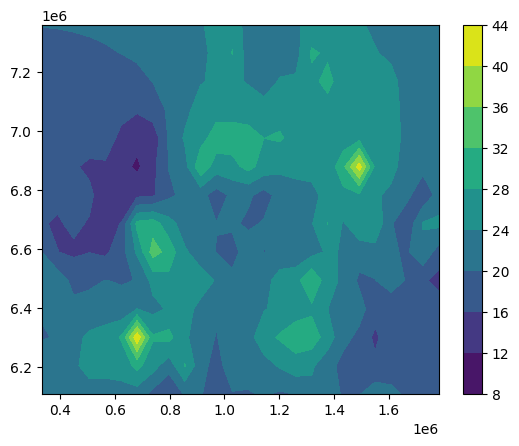

In [ ]:
# draw map
resolution = 2

X, Y = get_map_grid(polygon, map_boundary, resolution)
grid = np.array((Y, X)).T
map = np.empty((0, X.shape[0]))
certainty_map = np.empty((0, X.shape[0]))

for vertical_line in tqdm(grid):
    pred, stdv = gp.predict(vertical_line, return_std=True)
    pred = np.exp(pred + average)
    map = np.vstack((map, pred + average))
    certainty_map = np.vstack((certainty_map, stdv))

map = map.T
certainty_map = certainty_map.T

map_path = f'intermediate/map_gp_{region}.tif'
save_as_raster(map, polygon, map_boundary, region=region, method='gp', resolution=resolution)
# TODO: we cannot prevent the learned function to not go really high
# (this might especially happen outside the range of the seen data)
map = np.clip(map, 0, 400)
plt.contourf(X, Y, map)
plt.colorbar()
plt.show()

In [ ]:
build_map(
    method="gp",
    resolution=2,
    points=points,
    all_points=points,
    region="europe",
    polygon=polygon,
)

Loading country shapes...
Transforming heatmap...
max map waiting time: 63.32446056836346
min map waiting time: -1.0


/hpi/fs00/home/till.wenke/hitchmap-data/visualization/predictors/map_utils.py:325: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  countries = gpd.datasets.get_path("naturalearth_lowres")


Plotting heatmap...
max waiting time: 1440.1
[-1, -1.1, -0.40898200223895453, 0.5313382691995661, 2.0274047447178036, 4.407673433114255, 8.194723755860085, 14.219988977775479, 23.80629438712657, 39.05827882543822, 63.32446056836345, 1441.1]


ValueError: bins must be monotonically increasing or decreasing

ValueError: bins must be monotonically increasing or decreasing

<Figure size 10000x10000 with 2 Axes>

In [ ]:
stop

NameError: name 'stop' is not defined

#### 2 rbfs

In [ ]:
# log space
points = get_points('../data/points_train.csv')
# for log transformation make sure waiting times are above 0 otherwise we get -inf for those values
points['wait'] = points['wait'].apply(lambda x: 0.1 if x == 0 else x)
region = 'europe'
points, polygon, map_boundary = get_points_in_region(points, region)
points['lat'] = points.geometry.y
points['lon'] = points.geometry.x

X = points[['lat', 'lon']].values
y = points['wait'].values

# y_ being the waiting time in the (new) log space
# log space allows us to contrain the prior of functions (in the original space)
# to functions being always positive
# underlying cause: the original ys are not normally distributed (as they do not become less than 0)
y_ = np.log(y)

# assuming mean = 0 in the gp setup
average = np.mean(y_)
y_ = y_ - average
stdv = np.std(y_)

In [ ]:
# parameters to optimize

l = 6.42e5
L = [l, l]
sigma = stdv

rbf = RBF(
    length_scale=l, length_scale_bounds='fixed'
)  # using anisotripic kernel (different length scales for each dimension)
rbf2 = RBF(
    length_scale=5.35e4, length_scale_bounds='fixed'
)  # using anisotripic kernel (different length scales for each dimension)

kernel = (
    ConstantKernel(constant_value=sigma**2, constant_value_bounds=(1e-2, 1e1)) * rbf
    + ConstantKernel(constant_value=sigma**2, constant_value_bounds=(1e-2, 1e2)) * rbf2
    + WhiteKernel(noise_level=1.05e0, noise_level_bounds=(1e-1, 5e-1))
)

gp = GaussianProcessRegressor(
    kernel=kernel,
    alpha=0.0**2,
    optimizer="fmin_l_bfgs_b",  # maximizing marginal log lik: given the data, how likely is the parameterization of the kernel
    # (if we draw a sample frome the multivariate gaussian with the kernel as covariance matrix, how likely is the data we have seen)
    # prevents overfitting to some degree
    normalize_y=False,
    n_restarts_optimizer=0,
    random_state=42,
)

gp.fit(X, y_)
print(gp.kernel_, np.exp(gp.kernel_.theta))

# training error
points["pred"], points["std"] = gp.predict(X, return_std=True)
points["pred"] = np.exp(points["pred"] + average)

print(
    (
        mean_squared_error(points["wait"], points["pred"]),
        root_mean_squared_error(points["wait"], points["pred"]),
        mean_absolute_error(points["wait"], points["pred"]),
    )
)

# validation error
val = get_points("../data/points_val.csv")
val, polygon, map_boundary = get_points_in_region(val, region)
val["lat"] = val.geometry.y
val["lon"] = val.geometry.x

val["pred"], val["std"] = gp.predict(val[["lat", "lon"]].values, return_std=True)
val["pred"] = np.exp(val["pred"] + average)

print(
    (
        mean_squared_error(val["wait"], val["pred"]),
        root_mean_squared_error(val["wait"], val["pred"]),
        mean_absolute_error(val["wait"], val["pred"]),
    )
)

/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.5. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0.185**2 * RBF(length_scale=6.42e+05) + 0.629**2 * RBF(length_scale=5.35e+04) + WhiteKernel(noise_level=0.5) [0.03419219 0.39593149 0.5       ]
(3761.426384020647, 61.33046864341285, 23.122877834123088)
(3646.628904442371, 60.38732403776782, 25.424081980040448)


100%|██████████| 171/171 [00:34<00:00,  5.02it/s]


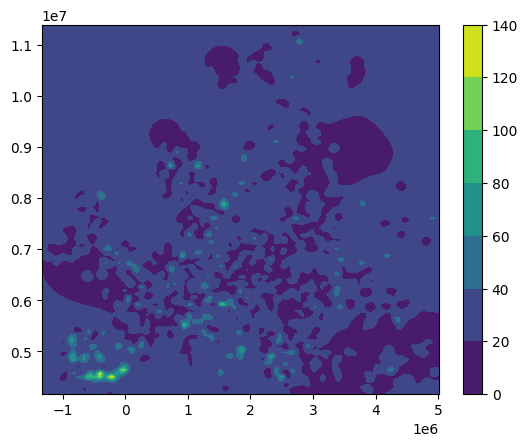

In [ ]:
# draw map
resolution = 3

X, Y = get_map_grid(polygon, map_boundary, resolution)
grid = np.array((Y, X)).T
map = np.empty((0, X.shape[0]))
certainty_map = np.empty((0, X.shape[0]))

for vertical_line in tqdm(grid):
    pred, stdv = gp.predict(vertical_line, return_std=True)
    pred = np.exp(pred + average)
    map = np.vstack((map, pred + average))
    certainty_map = np.vstack((certainty_map, stdv))

map = map.T
certainty_map = certainty_map.T

map_path = f'intermediate/map_gp_{region}.tif'
save_as_raster(map, polygon, map_boundary, region=region, method='gp', resolution=resolution)

# TODO: we cannot prevent the learned function to not go really high
# (this might especially happen outside the range of the seen data)
map = np.clip(map, 0, 400)
plt.contourf(X, Y, map)
plt.colorbar()
plt.show()

In [ ]:
build_map(
    method="gp",
    resolution=resolution,
    points=points,
    all_points=points,
    region=region,
    polygon=polygon,
)

Loading country shapes...
Transforming heatmap...
max map waiting time: 127.94707075813292
min map waiting time: 3.688336006936555
Plotting heatmap...
max waiting time: 1440.1
[3.688336006936555, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


/hpi/fs00/home/till.wenke/hitchmap-data/visualization/predictors/map_utils.py:325: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  countries = gpd.datasets.get_path("naturalearth_lowres")


#### 3 rbfs

In [ ]:
# parameters to optimize

l = 6.42e5
L = [l, l]
sigma = stdv

rbf = RBF(
    length_scale=5e4, length_scale_bounds=(5e4,1e5)
)  # using anisotripic kernel (different length scales for each dimension)
rbf2 = RBF(
    length_scale=1e5, length_scale_bounds=(1e5,5e5)
)  # using anisotripic kernel (different length scales for each dimension)
rbf3 = RBF(
    length_scale=5e5, length_scale_bounds=(5e5,1e6)
)  # using anisotripic kernel (different length scales for each dimension)

kernel = (
    ConstantKernel(constant_value=sigma**2, constant_value_bounds=(1e-2, 1e1)) * rbf
    + ConstantKernel(constant_value=sigma**2, constant_value_bounds=(1e-2, 1e2)) * rbf2
    + ConstantKernel(constant_value=sigma**2, constant_value_bounds=(1e-2, 1e2)) * rbf3
    + WhiteKernel(noise_level=1.05e0, noise_level_bounds=(1e-1, 1e1))
)

gp = GaussianProcessRegressor(
    kernel=kernel,
    alpha=0.0**2,
    optimizer="fmin_l_bfgs_b",  # maximizing marginal log lik: given the data, how likely is the parameterization of the kernel
    # (if we draw a sample frome the multivariate gaussian with the kernel as covariance matrix, how likely is the data we have seen)
    # prevents overfitting to some degree
    normalize_y=False,
    n_restarts_optimizer=0,
    random_state=42,
)

gp.fit(X, y_)
print(gp.kernel_, np.exp(gp.kernel_.theta))

# training error
points["pred"], points["std"] = gp.predict(X, return_std=True)
points["pred"] = np.exp(points["pred"] + average)

print(
    (
        mean_squared_error(points["wait"], points["pred"]),
        root_mean_squared_error(points["wait"], points["pred"]),
        mean_absolute_error(points["wait"], points["pred"]),
    )
)

# validation error
val = get_points("../data/points_val.csv")
val, polygon, map_boundary = get_points_in_region(val, region)
val["lat"] = val.geometry.y
val["lon"] = val.geometry.x

val["pred"], val["std"] = gp.predict(val[["lat", "lon"]].values, return_std=True)
val["pred"] = np.exp(val["pred"] + average)

print(
    (
        mean_squared_error(val["wait"], val["pred"]),
        root_mean_squared_error(val["wait"], val["pred"]),
        mean_absolute_error(val["wait"], val["pred"]),
    )
)

/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__length_scale is close to the specified lower bound 50000.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 500000.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.329**2 * RBF(length_scale=5e+04) + 0.133**2 * RBF(length_scale=2.37e+05) + 0.209**2 * RBF(length_scale=5e+05) + WhiteKernel(noise_level=1.08) [1.08256310e-01 5.00000000e+04 1.75874977e-02 2.37435454e+05
 4.36048302e-02 5.00000000e+05 1.08471899e+00]
(4021.2719590421766, 63.41349981701197, 24.359348580485992)
(3704.766656766781, 60.866794369071066, 25.17869070478298)


100%|██████████| 171/171 [00:31<00:00,  5.45it/s]


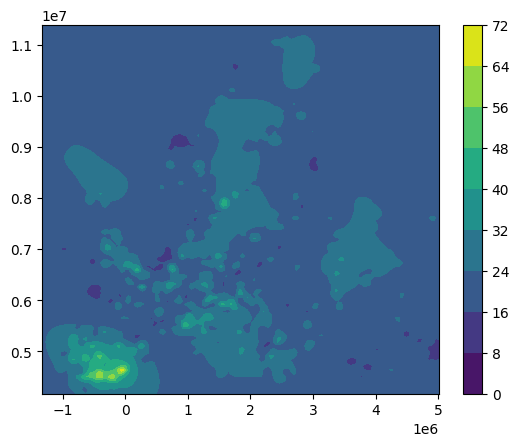

In [ ]:
# draw map
resolution = 3

X, Y = get_map_grid(polygon, map_boundary, resolution)
grid = np.array((Y, X)).T
map = np.empty((0, X.shape[0]))
certainty_map = np.empty((0, X.shape[0]))

for vertical_line in tqdm(grid):
    pred, stdv = gp.predict(vertical_line, return_std=True)
    pred = np.exp(pred + average)
    map = np.vstack((map, pred + average))
    certainty_map = np.vstack((certainty_map, stdv))

map = map.T
certainty_map = certainty_map.T

map_path = f'intermediate/map_gp_{region}.tif'
save_as_raster(map, polygon, map_boundary, region=region, method='gp', resolution=resolution)

# TODO: we cannot prevent the learned function to not go really high
# (this might especially happen outside the range of the seen data)
map = np.clip(map, 0, 400)
plt.contourf(X, Y, map)
plt.colorbar()
plt.show()


In [ ]:
build_map(
    method="gp",
    resolution=resolution,
    points=points,
    all_points=points,
    region=region,
    polygon=polygon,)

Loading country shapes...
Transforming heatmap...
max map waiting time: 68.14518779300225
min map waiting time: 7.702113265532043
Plotting heatmap...
max waiting time: 1440.1
[7.702113265532043, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


/hpi/fs00/home/till.wenke/hitchmap-data/visualization/predictors/map_utils.py:325: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  countries = gpd.datasets.get_path("naturalearth_lowres")


#### standard kernel

In [ ]:
# log space
points = get_points('../data/points_train.csv')
# for log transformation make sure waiting times are above 0 otherwise we get -inf for those values
points['wait'] = points['wait'].apply(lambda x: 0.1 if x == 0 else x)
region = 'europe'
points, polygon, map_boundary = get_points_in_region(points, region)
points['lat'] = points.geometry.y
points['lon'] = points.geometry.x

X = points[['lat', 'lon']].values
y = points['wait'].values

# y_ being the waiting time in the (new) log space
# log space allows us to contrain the prior of functions (in the original space)
# to functions being always positive
# underlying cause: the original ys are not normally distributed (as they do not become less than 0)
y_ = np.log(y)

# assuming mean = 0 in the gp setup
average = np.mean(y_)
y_ = y_ - average
stdv = np.std(y_)

In [ ]:
# tuning hyperparameters - length scale and noise level

l = 1e5
L = [l, l]
sigma = stdv

rbf = RBF(
    length_scale=L, length_scale_bounds=(1e-100, 1e100)
)  # using anisotripic kernel (different length scales for each dimension)

kernel = ConstantKernel(
    constant_value=sigma**2, constant_value_bounds="fixed"
) * rbf + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-100, 1e100))

gp = GaussianProcessRegressor(
    kernel=kernel,
    alpha=0.0**2,
    optimizer="fmin_l_bfgs_b",  # maximizing marginal log lik: given the data, how likely is the parameterization of the kernel
    # (if we draw a sample frome the multivariate gaussian with the kernel as covariance matrix, how likely is the data we have seen)
    # prevents overfitting to some degree
    normalize_y=False,
    n_restarts_optimizer=0,
    random_state=42,
)

# have to fit once before using log_marginal_likelihood
gp.fit(X, y_)
print(gp.kernel_, np.exp(gp.kernel_.theta))

num = 10
length_scale = np.logspace(4, 7, num=num)
noise_level = np.logspace(0, 1, num=num)
length_scale_grid, noise_level_grid = np.meshgrid(length_scale, noise_level)

print("Calculating log marginal likelihood...")
log_marginal_likelihood = [
    gp.log_marginal_likelihood(theta=np.log([scale, scale, noise]))
    for scale, noise in tqdm(zip(length_scale_grid.ravel(), noise_level_grid.ravel()), total=len(length_scale_grid.ravel()))
]
log_marginal_likelihood = np.reshape(
    log_marginal_likelihood, newshape=noise_level_grid.shape
)

print("Plotting...")
vmin, vmax = (-log_marginal_likelihood).min(), (-log_marginal_likelihood).max()
level = np.around(np.logspace(np.log10(vmin), np.log10(vmax), num=50), decimals=1)
plt.contour(
    length_scale_grid,
    noise_level_grid,
    -log_marginal_likelihood,
    levels=level,
    norm=LogNorm(vmin=vmin, vmax=vmax),
)
plt.colorbar()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Length-scale")
plt.ylabel("Noise-level")
plt.title("Log-marginal-likelihood")
plt.show()

/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-100. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified lower bound 1e-100. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


1.12**2 * RBF(length_scale=[1e-100, 1e-100]) + WhiteKernel(noise_level=4.83e-26) [1.00000000e-100 1.00000000e-100 4.83222604e-026]
Calculating log marginal likelihood...


 34%|███▍      | 34/100 [03:28<06:56,  6.32s/it]

KeyboardInterrupt: 

In [ ]:
# tuning hyperparameters - 2 independent length scales

l = 1e5
L = [l, l]
sigma = stdv

rbf = RBF(
    length_scale=L, length_scale_bounds=(1e-100, 1e100)
)  # using anisotripic kernel (different length scales for each dimension)

kernel = ConstantKernel(
    constant_value=sigma**2, constant_value_bounds="fixed"
) * rbf + WhiteKernel(noise_level=1.05e0, noise_level_bounds='fixed')

gp = GaussianProcessRegressor(
    kernel=kernel,
    alpha=0.0**2,
    optimizer="fmin_l_bfgs_b",  # maximizing marginal log lik: given the data, how likely is the parameterization of the kernel
    # (if we draw a sample frome the multivariate gaussian with the kernel as covariance matrix, how likely is the data we have seen)
    # prevents overfitting to some degree
    normalize_y=False,
    n_restarts_optimizer=0,
    random_state=42,
)

# have to fit once before using log_marginal_likelihood aka show the data
gp.fit(X, y_)
print(gp.kernel_, np.exp(gp.kernel_.theta))

num = 10
length_scale1 = np.logspace(5, 6, num=num)
length_scale2 = np.logspace(5, 6, num=num)
length_scale1_grid, length_scale2_grid = np.meshgrid(length_scale1, length_scale2)

print("Calculating log marginal likelihood...")
log_marginal_likelihood = [
    gp.log_marginal_likelihood(theta=np.log([scale1, scale2]))
    for scale1, scale2 in tqdm(zip(length_scale1_grid.ravel(), length_scale2_grid.ravel()), total=len(length_scale1_grid.ravel()))
]
log_marginal_likelihood = np.reshape(
    log_marginal_likelihood, newshape=length_scale2_grid.shape
)

print("Plotting...")
vmin, vmax = (-log_marginal_likelihood).min(), (-log_marginal_likelihood).max()
level = np.around(np.logspace(np.log10(vmin), np.log10(vmax), num=50), decimals=1)
plt.contour(
    length_scale1_grid,
    length_scale2_grid,
    -log_marginal_likelihood,
    levels=level,
    norm=LogNorm(vmin=vmin, vmax=vmax),
)
plt.colorbar()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Length-scale for lat")
plt.ylabel("Length-scale for lon")
plt.title("Log-marginal-likelihood")
plt.show()

KeyboardInterrupt: 

In [ ]:
# parameters to optimize 

l = 1e5
L = [l, l]
sigma = stdv

rbf = RBF(
length_scale=l, length_scale_bounds=(1e4, 1e6)
)  # using anisotripic kernel (different length scales for each dimension)

kernel = ConstantKernel(constant_value=sigma**2, constant_value_bounds="fixed") * rbf + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-1, 1e1))

gp = GaussianProcessRegressor(
kernel=kernel,
alpha=0.0**2,
optimizer="fmin_l_bfgs_b",  # maximizing marginal log lik: given the data, how likely is the parameterization of the kernel
# (if we draw a sample frome the multivariate gaussian with the kernel as covariance matrix, how likely is the data we have seen)
# prevents overfitting to some degree
normalize_y=False,
n_restarts_optimizer=0,
random_state=42,
)

gp.fit(X, y_)
print(gp.kernel_, np.exp(gp.kernel_.theta))

# training error
points["pred"], points["std"] = gp.predict(X, return_std=True)
points["pred"] = np.exp(points["pred"] + average)

print((mean_squared_error(points["wait"], points["pred"]), 
root_mean_squared_error(points["wait"], points["pred"]),
mean_absolute_error(points["wait"], points["pred"])))

# validation error
val = get_points('../data/points_val.csv')
val, polygon, map_boundary = get_points_in_region(val, region)
val['lat'] = val.geometry.y
val['lon'] = val.geometry.x

val['pred'], val['std'] = gp.predict(val[['lat', 'lon']].values, return_std=True)
val['pred'] = np.exp(val['pred'] + average)

print((mean_squared_error(val['wait'], val['pred']),
root_mean_squared_error(val['wait'], val['pred']),
mean_absolute_error(val['wait'], val['pred'])))



1.12**2 * RBF(length_scale=6.42e+05) + WhiteKernel(noise_level=1.18) [6.42279055e+05 1.18149829e+00]
(4164.42297907349, 64.53234056714113, 25.538913224337808)
(3773.125444923647, 61.42577183010114, 25.736310404478512)


In [ ]:
# baseline
points["baseline"] = np.exp(average)

print((mean_squared_error(points["wait"], points["baseline"]), 
root_mean_squared_error(points["wait"], points["baseline"]),
mean_absolute_error(points["wait"], points["baseline"])))

val['baseline'] = np.exp(average)

print((mean_squared_error(val['wait'], val['baseline']),
root_mean_squared_error(val['wait'], val['baseline']),
mean_absolute_error(val['wait'], val['baseline'])))

(5236.317836212746, 72.3624062356466, 27.306174288089302)
(3847.8985429902314, 62.03143189537246, 25.946905396160133)


In [ ]:
# draw map
resolution = 5

X, Y = get_map_grid(polygon, map_boundary, resolution)
grid = np.array((Y, X)).T
map = np.empty((0, X.shape[0]))
certainty_map = np.empty((0, X.shape[0]))

for vertical_line in tqdm(grid):
    pred, stdv = gp.predict(vertical_line, return_std=True)
    pred = np.exp(pred + average)
    map = np.vstack((map, pred + average))
    certainty_map = np.vstack((certainty_map, stdv))

map = map.T
certainty_map = certainty_map.T

save_as_raster(map, polygon, map_boundary, region=region, method='gp', resolution=resolution)

100%|██████████| 285/285 [00:41<00:00,  6.80it/s]


array([[22.18917615, 22.1912104 , 22.19337238, ..., 22.16412009,
        22.16593027, 22.16734517],
       [22.19211981, 22.19449551, 22.19702069, ..., 22.1636739 ,
        22.1656072 , 22.16711911],
       [22.19549514, 22.19826263, 22.20120461, ..., 22.16322429,
        22.16528696, 22.16690085],
       ...,
       [17.93526771, 17.61518137, 17.30527671, ..., 15.81742916,
        15.56445606, 15.33976769],
       [17.92115947, 17.58886939, 17.26480267, ..., 16.0860266 ,
        15.8380436 , 15.61753926],
       [17.91464189, 17.57127797, 17.23424322, ..., 16.36061185,
        16.11829809, 15.90257044]])

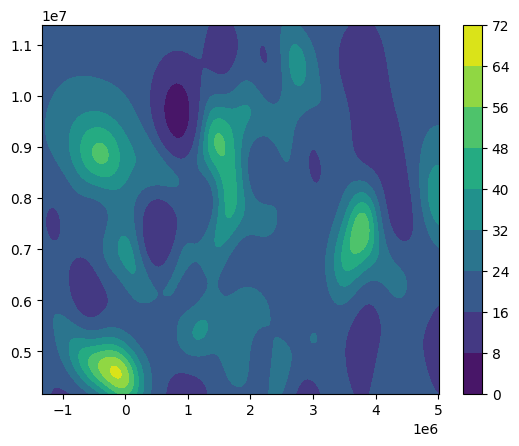

In [ ]:
# TODO: we cannot prevent the learned function to not go really high
# (this might especially happen outside the range of the seen data)
#map = np.clip(map, 0, 400)
plt.contourf(X, Y, map)
plt.colorbar()
plt.show()

In [ ]:
# parameters to optimize 

l = 1e5
L = [l, l]
sigma = stdv

rbf = RBF(
length_scale=l, length_scale_bounds=(1e4, 1e6)
)  # using anisotripic kernel (different length scales for each dimension)

kernel = ConstantKernel(constant_value=sigma**2, constant_value_bounds=(1e-1, 1e1)) * rbf + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-1, 1e1))

gp = GaussianProcessRegressor(
kernel=kernel,
alpha=0.0**2,
optimizer="fmin_l_bfgs_b",  # maximizing marginal log lik: given the data, how likely is the parameterization of the kernel
# (if we draw a sample frome the multivariate gaussian with the kernel as covariance matrix, how likely is the data we have seen)
# prevents overfitting to some degree
normalize_y=False,
n_restarts_optimizer=0,
random_state=42,
)

gp.fit(X, y_)
print(gp.kernel_, np.exp(gp.kernel_.theta))

# training error
points["pred"], points["std"] = gp.predict(X, return_std=True)
points["pred"] = np.exp(points["pred"] + average)

print((mean_squared_error(points["wait"], points["pred"]), 
root_mean_squared_error(points["wait"], points["pred"]),
mean_absolute_error(points["wait"], points["pred"])))

# validation error
val = get_points('../data/points_val.csv')
val, polygon, map_boundary = get_points_in_region(val, region)
val['lat'] = val.geometry.y
val['lon'] = val.geometry.x

val['pred'], val['std'] = gp.predict(val[['lat', 'lon']].values, return_std=True)
val['pred'] = np.exp(val['pred'] + average)

print((mean_squared_error(val['wait'], val['pred']),
root_mean_squared_error(val['wait'], val['pred']),
mean_absolute_error(val['wait'], val['pred'])))



0.388**2 * RBF(length_scale=5.35e+04) + WhiteKernel(noise_level=1.08) [1.50379579e-01 5.35442532e+04 1.08404005e+00]
(4031.7953250688515, 63.49641978150305, 24.342642884985345)
(3717.149611100617, 60.968431266521996, 25.183915651158372)


100%|██████████| 285/285 [01:03<00:00,  4.48it/s]


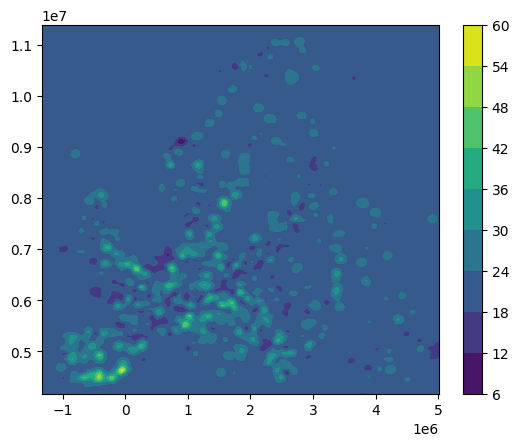

In [ ]:
# draw map
resolution = 5

X, Y = get_map_grid(polygon, map_boundary, resolution)
grid = np.array((Y, X)).T
map = np.empty((0, X.shape[0]))
certainty_map = np.empty((0, X.shape[0]))

for vertical_line in tqdm(grid):
    pred, stdv = gp.predict(vertical_line, return_std=True)
    pred = np.exp(pred + average)
    map = np.vstack((map, pred + average))
    certainty_map = np.vstack((certainty_map, stdv))

map = map.T
certainty_map = certainty_map.T

save_as_raster(map, polygon, map_boundary, region=region, method='gp', resolution=resolution)

plt.contourf(X, Y, map)
plt.colorbar()
plt.show()

In [ ]:
build_map(
    method="gp",
    resolution=resolution,
    points=points,
    all_points=points,
    region=region,
    polygon=polygon,
)

Loading country shapes...
Transforming heatmap...
max map waiting time: 68.921375724198
min map waiting time: 7.755059873709805
Plotting heatmap...
max waiting time: 1440.1
[-1, 7.6550598737098055, 8.337341931331048, 9.258676383579918, 10.716487356441602, 13.023155502204013, 16.672955122130336, 22.447967574652587, 31.585666160817794, 46.044082681658, 68.92137572419801, 1441.1]


/hpi/fs00/home/till.wenke/hitchmap-data/visualization/predictors/map_utils.py:325: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  countries = gpd.datasets.get_path("naturalearth_lowres")


In [ ]:
stop

NameError: name 'stop' is not defined

In [ ]:
from utils import *
from map_utils import *
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF,
    ConstantKernel,
    WhiteKernel,
    ExpSineSquared,
    RationalQuadratic,
)
import pickle
from sklearn.metrics import (
    root_mean_squared_error,
    mean_squared_error,
    mean_absolute_error,
)
import numpy as np
import seaborn as sns
import matplotlib
import shapely
from matplotlib.colors import LogNorm
import logging

logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

logger.info("Starting")

# log space
points = get_points("../data/points_train.csv")
# for log transformation make sure waiting times are above 0 otherwise we get -inf for those values
points["wait"] = points["wait"].apply(lambda x: 0.1 if x == 0 else x)
region = "germany"
points, polygon, map_boundary = get_points_in_region(points, region)
points["lat"] = points.geometry.y
points["lon"] = points.geometry.x

X = points[["lat", "lon"]].values
y = points["wait"].values

# y_ being the waiting time in the (new) log space
# log space allows us to contrain the prior of functions (in the original space)
# to functions being always positive
# underlying cause: the original ys are not normally distributed (as they do not become less than 0)
y_ = np.log(y)

# assuming mean = 0 in the gp setup
average = np.mean(y_)
y_ = y_ - average
stdv = np.std(y_)

# parameters to optimize

l = 1e5
L = [l, l]
sigma = stdv

rqk = RationalQuadratic(
    length_scale=1e5,
    alpha=1.0,
    length_scale_bounds=(1e-1, 1e6),
    alpha_bounds=(1e-05, 100000.0),
)

kernel = ConstantKernel(
    constant_value=sigma**2, constant_value_bounds=(1e-1, 1e1)
) * rqk + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-2, 1e2))

gp = GaussianProcessRegressor(
    kernel=kernel,
    alpha=0.0**2,
    optimizer="fmin_l_bfgs_b",  # maximizing marginal log lik: given the data, how likely is the parameterization of the kernel
    # (if we draw a sample frome the multivariate gaussian with the kernel as covariance matrix, how likely is the data we have seen)
    # prevents overfitting to some degree
    normalize_y=False,
    n_restarts_optimizer=1,
    random_state=42,
)

logger.info("Fitting GP...")
gp.fit(X, y_)
logger.info(str(gp.kernel_), np.exp(gp.kernel_.theta))

INFO:__main__:Starting
INFO:__main__:Fitting GP...
100%|██████████| 1/1 [00:19<00:00, 19.95s/it]
--- Logging error ---
Traceback (most recent call last):
  File "/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/logging/__init__.py", line 1100, in emit
    msg = self.format(record)
  File "/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/logging/__init__.py", line 943, in format
    return fmt.format(record)
  File "/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/logging/__init__.py", line 678, in format
    record.message = record.getMessage()
  File "/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/logging/__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File

In [ ]:
logger.info((str(gp.kernel_), np.exp(gp.kernel_.theta)))

INFO:__main__:('1.09**2 * RationalQuadratic(alpha=0.0232, length_scale=2.82) + WhiteKernel(noise_level=0.563)', array([1.18000085, 0.0231664 , 2.82074855, 0.56299857]))


In [ ]:
# training error
logger.info("Training error...")
points["pred"], points["std"] = gp.predict(X, return_std=True)
points["pred"] = np.exp(points["pred"] + average)

logger.info(
    (
        mean_squared_error(points["wait"], points["pred"]),
        root_mean_squared_error(points["wait"], points["pred"]),
        mean_absolute_error(points["wait"], points["pred"]),
    )
)

# validation error
logger.info("Validation error...")
val = get_points("../data/points_val.csv")
val, polygon, map_boundary = get_points_in_region(val, region)
val["lat"] = val.geometry.y
val["lon"] = val.geometry.x

val["pred"], val["std"] = gp.predict(val[["lat", "lon"]].values, return_std=True)
val["pred"] = np.exp(val["pred"] + average)

logger.info(
    (
        mean_squared_error(val["wait"], val["pred"]),
        root_mean_squared_error(val["wait"], val["pred"]),
        mean_absolute_error(val["wait"], val["pred"]),
    )
)

with open(f"./models/{region}_rqk.pkl", "wb") as f:
    pickle.dump(gp, f)

gp = pickle.load(open(f"./models/{region}_rqk.pkl", "rb"))

# draw map
resolution = 3

make_map_from_gp(gp, average, region, polygon, map_boundary, resolution=resolution)

build_map(
    method="gp",
    resolution=resolution,
    points=points,
    all_points=points,
    region=region,
    polygon=polygon,
)


## Map drawing

In [ ]:
# log space
points = get_points('../data/points_train.csv')
# for log transformation make sure waiting times are above 0 otherwise we get -inf for those values
points['wait'] = points['wait'].apply(lambda x: 0.1 if x == 0 else x)
region = 'world'
points, polygon, map_boundary = get_points_in_region(points, region)
points['lat'] = points.geometry.y
points['lon'] = points.geometry.x

X = points[['lat', 'lon']].values
y = points['wait'].values

# y_ being the waiting time in the (new) log space
# log space allows us to contrain the prior of functions (in the original space)
# to functions being always positive
# underlying cause: the original ys are not normally distributed (as they do not become less than 0)
y_ = np.log(y)

# assuming mean = 0 in the gp setup
average = np.mean(y_)
y_ = y_ - average
stdv = np.std(y_)

In [ ]:
def bm(
    method="ORDINARY",
    resolution=RESOLUTION,
    points=None,
    all_points=None,
    region="world",
    polygon=None,
    show_states=False,
    show_cities=False,
    show_roads=False,
    show_spots=False,
    certainty=None,
):
    map_path = f"intermediate/map_{method}_{region}_{resolution}.tif"
    
    # print("Loading information about states...")
    # states = gpd.read_file("map_features/states/ne_10m_admin_1_states_provinces.shp")
    # states = states.to_crs(epsg=3857)

    # # use smaller units for Russia
    # # country level except for Canada, Russia, USA, Australia, China, Brazil, India, Indonesia
    # states = states[states.admin != "Antarctica"]

    # # a state is hitchhikable if there are hitchhiking spots in it
    # def check_hitchhikability(state):
    #     points_in_state = points[points.geometry.within(state.geometry)]
    #     return len(points_in_state) > 0

    # print("Checking hitchhikability for each state...")
    # states["hh"] = states.progress_apply(check_hitchhikability, axis=1)

    fig, ax = plt.subplots(figsize=(100, 100))

    # get borders of all countries
    # download https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/110m/cultural/ne_110m_admin_0_countries.zip
    # from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/
    
    print("Loading country shapes...")
    countries = gpd.datasets.get_path("naturalearth_lowres")
    countries = gpd.read_file(countries)
    countries = countries.to_crs(epsg=3857)
    countries = countries[countries.name != "Antarctica"]
    # TODO so far does not work as in final map the raster is not applied to the whole region
    # countries = countries[countries.geometry.within(polygon.geometry[0])]
    country_shapes = countries.geometry
    if show_states:
        countries.plot(ax=ax, facecolor="none", edgecolor="black")

    # TODO takes more time than expected
    # use a pre-compiled list of important cities
    # download https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_populated_places.zip
    # from https://www.naturalearthdata.com/downloads/10m-cultural-vectors/
    # cities = gpd.read_file("cities/ne_10m_populated_places.shp", bbox=polygon.geometry[0]) should work but does not
    if show_cities:
        print("Loading cities...")
        cities = gpd.read_file(
            "map_features/cities/ne_10m_populated_places.shp"
        )  # takes most time
        cities = cities.to_crs(epsg=3857)
        cities = cities[cities.geometry.within(polygon.geometry[0])]
        cities.plot(ax=ax, markersize=1, color="black")

    # use a pre-compiles list of important roads
    # download https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_roads.zip
    # from https://www.naturalearthdata.com/downloads/10m-cultural-vectors/
    if show_roads:
        print("Loading roads...")
        roads = gpd.read_file("map_features/roads/ne_10m_roads.shp")
        roads = roads.to_crs(epsg=3857)
        roads = roads[roads.geometry.within(polygon.geometry[0])]
        roads.plot(ax=ax, markersize=1, color="black")

    if show_spots:
        all_points.plot(ax=ax, markersize=10, color="red")

    # limit heatmap to landmass by asigning inf/ high value to sea
    print("Transforming heatmap...")
    nodata = np.nan
    with rasterio.open(map_path) as heatmap:
        max_map_wait = heatmap.read().max()
        min_map_wait = heatmap.read().min()
        print("max map waiting time:", max_map_wait)
        print("min map waiting time:", min_map_wait)

        out_image, out_transform = rasterio.mask.mask(
            heatmap, country_shapes, nodata=nodata
        )
        out_meta = heatmap.meta

    out_meta.update(
        {
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform,
        }
    )

    with rasterio.open(map_path, "w", **out_meta) as destination:
        destination.write(out_image)

    # plot the heatmap
    print("Plotting heatmap...")
    raster = rasterio.open(map_path)

    # TODO smoother spectrum instead of buckets
    buckets = [
        "#008200",  # dark green
        "#00c800",  # light green
        "#c8ff00",  # light yellow
        "#ffff00",  # yellow
        "#ffc800",  # light orange
        "#ff8200",  # dark orange
        "red",  # red
        "#c80000",  # dark red
        "#820000",  # wine red
        "#820000",  # drop?
    ]

    cmap = colors.ListedColormap(buckets)

    max_wait = (
        all_points.wait.max() + 0.1
    )  # to get at least this value as maximum for the colored buckets
    print("max waiting time:", max_wait)
    num_scale_colors = len(buckets) - 2  # because of upper and lower bucket
    # build log scale starting at 0 and ending at max wait
    base = (max_map_wait - min_map_wait + 1) ** (1 / num_scale_colors)

    def log_scale(x):
        return base**x - 1

    # define the heatmap color scale

    # how to prevent numerical instabilities resulting in some areas having a checkerboard pattern
    # round pixel values to ints
    # set the boundaries of the buckets to not be ints
    # should happen automatically through the log scale
    # -0.1 should be 0.0 actually
    # boundary of last bucket does not matter - values outside of the range are colored in the last bucket
    boundaries = (
        [-1, min_map_wait - 0.1]
        + [min_map_wait + log_scale(i) for i in range(1, num_scale_colors + 1)]
        + [max_wait + 1]
    )

    # values higher than the upper boundary are colored in the upmost color
    boundaries = (
        [min_map_wait, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    )

    print(boundaries)

    # prepare the plot
    norm = colors.BoundaryNorm(boundaries, cmap.N, clip=True)

    ax.set_facecolor('0.7') # background color light gray for landmass with uncertainty
    # let certainty have no influence on sea color
    certainty = np.where(np.isnan(raster.read()[0]), 1, certainty)
    # shift (for rational quadratic kernel)
    certainty = certainty + 0.4
    certainty = np.clip(certainty, 0, 1)

    # set color for nan (nodata... sea) values
    # from https://stackoverflow.com/questions/2578752/how-can-i-plot-nan-values-as-a-special-color-with-imshow
    cmap.set_bad(color='blue')
    rasterio.plot.show(raster, ax=ax, cmap=cmap, norm=norm, alpha=certainty)

    cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
    cbar.ax.tick_params(labelsize=50)
    if method == "ITERATIVE":
        file_name = f"maps/map_{region}_iter_{ITERATIONS}.png"
    elif method == "DYNAMIC":
        file_name = f"maps/map_{region}_{K}.png"
    elif method == "gp":
        file_name = f"maps/map_gp_{region}_{resolution}.png"
    else:
        file_name = f"maps/map_{region}.png"


In [ ]:
resolution = 2
map = load_numpy_map(region=region, method="gp", kind_of_map='map', resolution=resolution)
save_as_raster(map, polygon, map_boundary, region=region, method="gp", resolution=resolution)
c = load_numpy_map(region=region, method="gp", kind_of_map='certainty', resolution=resolution)
from sklearn.preprocessing import normalize
c = (c - c.min()) / (c.max() - c.min())
c = 1 - c

bm(
    method="gp",
    resolution=2,
    points=points,
    all_points=points,
    region=region,
    polygon=polygon,
    show_states=True,
    certainty=c
)

Loading country shapes...


/tmp/ipykernel_1516726/1158663481.py:39: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  countries = gpd.datasets.get_path("naturalearth_lowres")


Transforming heatmap...
max map waiting time: 234.94102840089462
min map waiting time: 5.5176824809281575
Plotting heatmap...
max waiting time: 1440.1
[5.5176824809281575, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


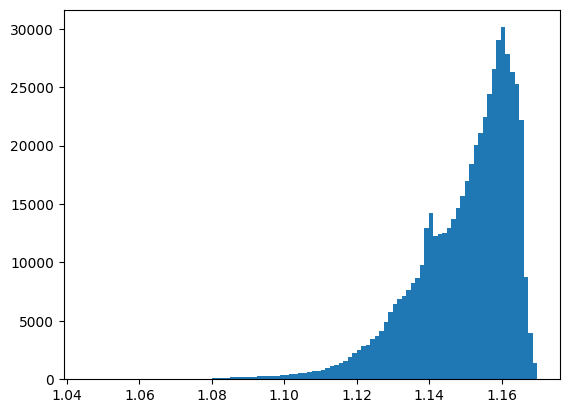

Loading country shapes...
Transforming heatmap...
max map waiting time: 1.1697306239848126
min map waiting time: 1.0453082679114745


/tmp/ipykernel_1516726/1158663481.py:39: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  countries = gpd.datasets.get_path("naturalearth_lowres")


Plotting heatmap...
max waiting time: 1440.1
[1.0453082679114745, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


TypeError: '<=' not supported between instances of 'int' and 'NoneType'

In [ ]:
resolution = 2
map = load_numpy_map(region=region, method="gp", kind_of_map='certainty', resolution=resolution)
map = save_as_raster(map, polygon, map_boundary, region=region, method="gp", resolution=resolution)
plt.hist(map.ravel(), bins=100)
plt.show()

In [ ]:
# TODO: check gamma distribution (problem here to high certainty in areas with no data)

resolution = 3
map = load_numpy_map(region=region, method="gp", kind_of_map='map', resolution=20)
save_as_raster(map, polygon, map_boundary, region=region, method="gp", resolution=resolution)
c = load_numpy_map(region=region, method="gp", kind_of_map='certainty', resolution=20)
from sklearn.preprocessing import normalize
c = (c - c.min()) / (c.max() - c.min())
c = 1 - c

bm(
    method="gp",
    resolution=resolution,
    points=points,
    all_points=points,
    region=region,
    polygon=polygon,
    show_states=True,
    certainty=c
)

Loading country shapes...


/tmp/ipykernel_1516726/1399770141.py:39: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  countries = gpd.datasets.get_path("naturalearth_lowres")


Transforming heatmap...
max map waiting time: 57.208337876052106
min map waiting time: 6.371227495186531
Plotting heatmap...
max waiting time: 1440.1
[6.371227495186531, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


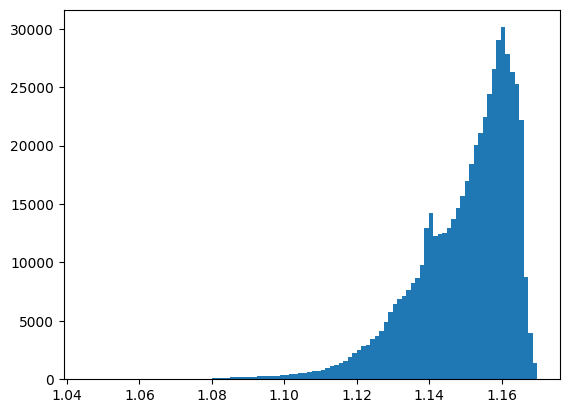

In [ ]:
resolution = 3
map = load_numpy_map(region=region, method="gp", kind_of_map='certainty', resolution=20)
map = save_as_raster(map, polygon, map_boundary, region=region, method="gp", resolution=resolution)
plt.hist(map.ravel(), bins=100)
plt.show()

In [ ]:
stop

NameError: name 'stop' is not defined

## experiment: does adding more data lead to a descrease of length scale?

In [ ]:
# as suggested here https://www.cs.toronto.edu/~duvenaud/cookbook/
points = get_points("../data/points_train.csv")
region = "germany"
points, polygon, map_boundary = get_points_in_region(points, region)
points["lat"] = points.geometry.y
points["lon"] = points.geometry.x

# split points into 10 splits
num_splits = 10
from numpy.random import RandomState

random = RandomState(42)
points["split"] = random.randint(0, num_splits, points.shape[0])

# parameters to optimize
sigma = 60
sigma_bounds = (60, 60)  # unit are minutes

l = [1e6, 1e6]  # only lon dimensions; set starting value to 1000km
length_scale_bounds = (
    1e1,
    1e7,
)  # from the scatter plot above; in the metirc crs this implies influence between 10km and 10000km

alpha = 5.0  # as WhiteKernel is used to optimized noise

rbf = RBF(
    length_scale=l, length_scale_bounds=length_scale_bounds
)  # using anisotripic kernel (different length scales for each dimension)

kernel = (
    ConstantKernel(constant_value=sigma**2, constant_value_bounds=np.power(sigma_bounds,2)) * rbf
)

for split in range(num_splits):

    p = points[points.split <= split]

    X = p[["lat", "lon"]].values
    y = p["wait"].values
    print(X.shape)

    average = np.mean(y)

    gp = GaussianProcessRegressor(
        kernel=kernel,
        alpha=alpha**2,
        optimizer="fmin_l_bfgs_b",  # maximizing marginal log lik: given the data, how likely is the parameterization of the kernel
        # (if we draw a sample frome the multivariate gaussian with the kernel as covariance matrix, how likely is the data we have seen)
        # prevents overfitting to some degree
        normalize_y=False,
        n_restarts_optimizer=10,
        random_state=42,
    )

    gp.fit(X, y - average)
    print(gp.kernel_, np.exp(gp.kernel_.theta))

(193, 2)


100%|██████████| 10/10 [00:00<00:00, 30.58it/s]
/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 3600. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified upper bound 10000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


60**2 * RBF(length_scale=[72, 1e+07]) [3.60000000e+03 7.19565319e+01 1.00000000e+07]
(352, 2)


100%|██████████| 10/10 [00:02<00:00,  3.45it/s]
/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 3600. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


60**2 * RBF(length_scale=[28.1, 1.87e+06]) [3.60000000e+03 2.81066477e+01 1.87206608e+06]
(532, 2)


100%|██████████| 10/10 [00:04<00:00,  2.14it/s]
/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 3600. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


60**2 * RBF(length_scale=[13, 2.12e+06]) [3.60000000e+03 1.29982605e+01 2.12126847e+06]
(681, 2)


100%|██████████| 10/10 [00:07<00:00,  1.42it/s]
/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 3600. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


60**2 * RBF(length_scale=[14.7, 2.11e+06]) [3.60000000e+03 1.46776707e+01 2.11005805e+06]
(852, 2)


100%|██████████| 10/10 [00:14<00:00,  1.41s/it]
/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 3600. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


60**2 * RBF(length_scale=[17, 2.41e+06]) [3.60000000e+03 1.69958177e+01 2.40599996e+06]
(1016, 2)


100%|██████████| 10/10 [00:28<00:00,  2.82s/it]
/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 3600. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


60**2 * RBF(length_scale=[15.9, 405]) [3600.           15.85651765  404.82556015]
(1179, 2)


100%|██████████| 10/10 [00:37<00:00,  3.73s/it]
/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 3600. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


60**2 * RBF(length_scale=[15.6, 3.17e+05]) [3.60000000e+03 1.56079687e+01 3.17091745e+05]
(1352, 2)


100%|██████████| 10/10 [00:52<00:00,  5.20s/it]
/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 3600. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


60**2 * RBF(length_scale=[13.6, 3.51e+05]) [3.60000000e+03 1.35635796e+01 3.50831695e+05]
(1514, 2)


100%|██████████| 10/10 [01:06<00:00,  6.64s/it]
/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 3600. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


60**2 * RBF(length_scale=[11.8, 3.45e+05]) [3.60000000e+03 1.18206892e+01 3.44621409e+05]
(1688, 2)


100%|██████████| 10/10 [01:08<00:00,  6.87s/it]

60**2 * RBF(length_scale=[16.4, 47.6]) [3600.           16.35143043   47.64923408]



/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 3600. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


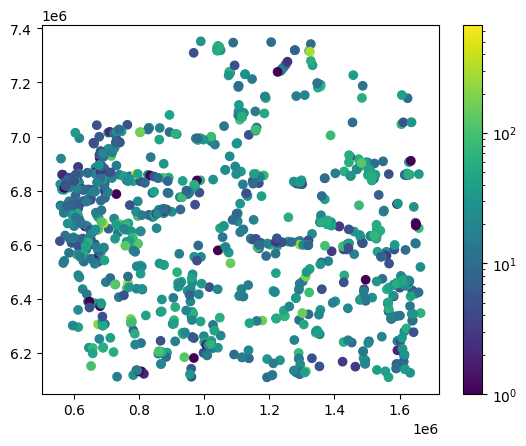

In [ ]:
plt.scatter(X[:,1], X[:,0], c=y, norm='log', label="Observations")
plt.colorbar()

In [ ]:
np.power((1,2),2)

array([1, 4])

# 3D using location and time when the spot was recorded (might use single ratings of spots here instead averaged)

# experimental


In [ ]:
# manual noise
# lets say for 5 min we want 95% confidence interval to lie between 0 and 10 min -> stdv = 2.5
# for 3 h we want 95% confidence interval to lie between 2.5 and 3.5 h -> stdv = 15.0

# see for improvement
# https://pubmed.ncbi.nlm.nih.gov/33083992/
# http://www.bccn-munich.de/research/bernstein-ii/individual-projects/project-b-t5-understanding-the-effects-of-temporal-context-on-interval-timing-a-model-based-approach
# TODO: learn a noise function (e.g. coefficient for a linear function)
def noise_from_waiting_time(wait):
    return 0.071 * wait + 2.145

v_noise_from_waiting_time = np.vectorize(noise_from_waiting_time)